<a href="https://colab.research.google.com/github/shaqas86/Langgraph_EcoSystem/blob/main/PanaversityConversational_Agent.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%capture --no-stderr
%pip install -U langgraph langsmith langchain_google_genai langchain_community

In [2]:
import os
from google.colab import userdata

os.environ["LANGCHAIN_API_KEY"] = userdata.get('LANGCHAIN_API_KEY')
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "DLIMS-Agentic-System"
os.environ["TAVILY_API_KEY"] = userdata.get('TAVILY_API_KEY')

gemini_api_key = userdata.get('GEMINI_API_KEY')
tavily_api_key = userdata.get('TAVILY_API_KEY')

In [3]:
from langchain_google_genai import ChatGoogleGenerativeAI

llm = ChatGoogleGenerativeAI(
    model="gemini-1.5-flash",
    max_retries=2,
    api_key=gemini_api_key
)

llm.invoke("greet me")

AIMessage(content='Hello there!  How are you doing today?\n', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run-c867db6c-873f-4962-a521-4114c4ff985f-0', usage_metadata={'input_tokens': 3, 'output_tokens': 11, 'total_tokens': 14, 'input_token_details': {'cache_read': 0}})

In [5]:
from typing import Optional, Dict, Any, List
from langgraph.graph import StateGraph, END, START
from langgraph.checkpoint.memory import MemorySaver
from langgraph.prebuilt import ToolNode
from langchain_core.tools import BaseTool
from pydantic import BaseModel, Field
from typing_extensions import override,TypedDict

# Define the application state
class State(TypedDict):
    messages: List[Dict[str, str]]
    user_profile: Dict[str, Any]
    profile_completion_stage: Optional[str]

# Custom Tool Classes
class LinkedInProfileTool(BaseTool):
    name: str = Field(default="linkedin_profile", description="Fetch professional profile data")
    description: str = "Tool to extract professional information from LinkedIn profile"

    @override
    def _run(self, linkedin_url: str, *args: Any, **kwargs: Any) -> Any:
        # Simulated LinkedIn profile data extraction
        # In a real-world scenario, this would use LinkedIn API or web scraping
        return {
            "name": "Sample Professional",
            "about": "Passionate tech enthusiast with 5+ years of experience",
            "work_experience": [
                {
                    "company": "Tech Innovations Inc.",
                    "role": "Senior Software Engineer",
                    "duration": "2020-Present"
                }
            ],
            "education": [
                {
                    "institution": "Tech University",
                    "degree": "Computer Science",
                    "graduation_year": 2020
                }
            ],
            "skills": ["Python", "Machine Learning", "AI", "Data Science"],
        }

class ProfileCompletionTool(BaseTool):
    name: str = Field(default="profile_completion", description="Complete user profile")
    description: str = "Tool to guide and complete user profile information"

    @override
    def _run(self, state: State, *args: Any, **kwargs: Any) -> Any:
        # Check profile completeness and provide guidance
        profile = state.get("user_profile", {})
        missing_fields = []

        required_fields = [
            "name", "email", "phone",
            "about", "work_experience",
            "education", "skills",
            "interests", "hobbies"
        ]

        for field in required_fields:
            if not profile.get(field):
                missing_fields.append(field)

        if missing_fields:
            return f"Please provide the following missing information: {', '.join(missing_fields)}"

        return {"status": "Profile Complete", "profile": profile}

class PanaversityPromptEngineeringTool(BaseTool):
    name: str = Field(default="prompt_engineering", description="Generate interaction prompts")
    description: str = "Tool to create specialized prompts for Panaversity agent interactions"

    @override
    def _run(self, *args: Any, **kwargs: Any) -> Any:
        # Generate a comprehensive system prompt for the Panaversity agent
        return """
        You are a helpful AI assistant for Panaversity, dedicated to creating comprehensive student profiles.

        Core Interaction Principles:
        1. Be warm, encouraging, and professional
        2. Guide students through profile creation step-by-step
        3. Provide clear instructions and helpful suggestions
        4. Validate and enrich provided information
        5. Respect student privacy and data confidentiality

        Profile Creation Flow:
        - Introduce yourself and the profile creation process
        - Ask for basic contact information
        - Request professional background details
        - Explore educational history
        - Capture skills, interests, and career aspirations
        - Offer personalized guidance based on provided information

        Interaction Style:
        - Use a conversational yet professional tone
        - Ask open-ended questions to encourage detailed responses
        - Provide examples when requesting specific information
        - Offer constructive feedback and suggestions
        """

# Instantiate tools
tools = [
    LinkedInProfileTool(),
    ProfileCompletionTool(),
    PanaversityPromptEngineeringTool()
]

# Dynamic tool selection
def tools_condition(state: State):
    profile = state.get("user_profile", {})

    if not profile.get("linkedin_data"):
        return "linkedin_profile"

    if not profile.get("is_complete"):
        return "profile_completion"

    return END

# Build the graph
graph_builder = StateGraph(State)

# Initialize state
def initialize_state(state: State):
    return {
        "messages": state.get("messages", []) + [
            {"role": "assistant", "content": "Welcome to Panaversity Profile Creator! Let's build your professional profile together."}
        ],
        "user_profile": state.get("user_profile", {}),
        "profile_completion_stage": "start"
    }

# Chatbot interaction node
def chatbot_node(state: State):
    return {
        "messages": state["messages"] + [
            {"role": "assistant", "content": "How can I help you complete your profile today?"}
        ]
    }

# Add nodes
graph_builder.add_node("initialize", initialize_state)
graph_builder.add_node("chatbot", chatbot_node)
graph_builder.add_node("tools", ToolNode(tools=tools))

# Conditional routing
def select_next_node(state: State):
    return tools_condition(state)

graph_builder.add_conditional_edges(
    "chatbot",
    select_next_node,
    {"tools": "tools", END: END},
)

# Add start and tool loops
graph_builder.add_edge(START, "initialize")
graph_builder.add_edge("initialize", "chatbot")
graph_builder.add_edge("tools", "chatbot")

# Compile graph
memory = MemorySaver()
graph = graph_builder.compile(
    checkpointer=memory
)

# Example interaction
def run_profile_creation(input_message):
    thread = {"configurable": {"thread_id": "unique_user_session"}}
    inputs = {"messages": [{"role": "human", "content": input_message}]}
    result = graph.invoke(inputs, thread)
    return result

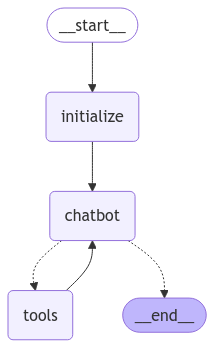

In [6]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [8]:
import asyncio
from typing import Dict, Any

# Assuming the previous code is already imported and the graph is created
# If not, make sure to include all the imports and graph creation code from the previous artifact

# Async interaction method
async def run_profile_creation_async(input_message: str) -> Dict[str, Any]:
    thread = {"configurable": {"thread_id": "unique_user_session"}}
    inputs = {
        "messages": [{"role": "human", "content": input_message}],
        "user_profile": {}  # Initialize with empty profile
    }

    # Use async invoke
    result = await graph.ainvoke(inputs, thread)
    return result

# Synchronous wrapper for async method
def run_profile_creation(input_message: str) -> Dict[str, Any]:
    return asyncio.run(run_profile_creation_async(input_message))

# Interactive conversation simulation
def simulate_conversation():
    print("Panaversity Profile Creator Agent")
    print("-------------------------------")

    # Conversation steps
    conversation_steps = [
        "Hi, I want to create my Panaversity profile",
        "My name is Ahmed Khan",
        "I want to share my LinkedIn profile",
        "https://linkedin.com/in/sample-profile",
        "I'm interested in AI and Machine Learning",
        "I graduated from FAST NUCES in Computer Science",
        "My skills include Python, Machine Learning, and Data Science",
        "I'm looking to join Panaversity's AI program"
    ]

    # Store conversation history
    conversation_history = []

    # Simulate conversation
    for user_input in conversation_steps:
        print(f"\nHuman: {user_input}")

        # Run the graph with the input
        result = run_profile_creation(user_input)

        # Extract and print assistant's response
        if result and 'messages' in result:
            assistant_response = result['messages'][-1]['content'] if result['messages'] else "No response"
            print(f"Assistant: {assistant_response}")

        # Optional: Print current state (for debugging)
        print("\nCurrent Profile State:")
        print(result.get('user_profile', 'No profile data yet'))

        # Add a small pause for readability
        asyncio.sleep(1)

# Main execution
if __name__ == "__main__":
    simulate_conversation()

# Additional interactive method for manual input
def interactive_agent_chat():
    print("Panaversity Profile Creator - Interactive Chat")
    print("Type 'exit' to end the conversation")

    while True:
        user_input = input("\nYou: ")

        if user_input.lower() == 'exit':
            break

        result = run_profile_creation(user_input)

        # Extract and print assistant's response
        if result and 'messages' in result:
            assistant_response = result['messages'][-1]['content'] if result['messages'] else "No response"
            print(f"Assistant: {assistant_response}")

        # Print current profile state
        print("\nCurrent Profile State:")
        print(result.get('user_profile', 'No profile data yet'))

# Uncomment the method you want to run
simulate_conversation()
# interactive_agent_chat()

Panaversity Profile Creator Agent
-------------------------------

Human: Hi, I want to create my Panaversity profile


/usr/local/lib/python3.10/dist-packages/jupyter_client/session.py:151: RuntimeWarning: coroutine 'run_profile_creation_async' was never awaited
  return datetime.utcnow().replace(tzinfo=utc)


RuntimeError: asyncio.run() cannot be called from a running event loop

In [11]:
async def run_profile_creation(graph, input_message):
    thread = {"configurable": {"thread_id": "unique_user_session"}}
    inputs = {
        "messages": [{"role": "human", "content": input_message}],
        "user_profile": {}
    }
    result = await graph.ainvoke(inputs, thread)
    return result

# Main conversation simulation
async def main():
    graph = create_profile_graph()

    # Conversation flow
    conversation = [
        "Hi, I want to create my Panaversity profile",
        "My name is Ahmed Khan",
        "Here's my LinkedIn profile: https://linkedin.com/in/sample",
        "My skills are Python, Machine Learning, and AI"
    ]

    for message in conversation:
        print(f"\nHuman: {message}")
        result = await run_profile_creation(graph, message)

        # Print assistant's response
        if result and 'messages' in result:
            assistant_response = result['messages'][-1]['content']
            print(f"Assistant: {assistant_response}")

        # Print current profile state
        print("Current Profile:", result.get('user_profile', {}))

# Run the conversation
if __name__ == "__main__":
    asyncio.run(main())

RuntimeError: asyncio.run() cannot be called from a running event loop

In [10]:
import asyncio
from typing import TypedDict, Optional, Dict, Any, List
from langgraph.graph import StateGraph, END, START
from langgraph.checkpoint.memory import MemorySaver
from langgraph.prebuilt import ToolNode
from langchain_core.tools import BaseTool
from pydantic import Field
from typing_extensions import override

# State Definition
class State(TypedDict):
    messages: List[Dict[str, str]]
    user_profile: Dict[str, Any]
    profile_completion_stage: Optional[str]

# Tools for Profile Creation
class ProfileTool(BaseTool):
    name: str = "profile_creator"
    description: str = "Tool to guide profile creation and data collection"

    @override
    def _run(self, state: State, *args: Any, **kwargs: Any) -> Any:
        # Simulate profile data collection and validation
        profile = state.get("user_profile", {})
        messages = state.get("messages", [])
        last_message = messages[-1]['content'] if messages else ""

        # Simple profile data extraction logic
        if "name" not in profile and "name is" in last_message.lower():
            name = last_message.split("name is")[-1].strip()
            profile["name"] = name
            return {"user_profile": profile, "message": f"Great! I've added {name} to your profile."}

        if "linkedin" in last_message.lower():
            profile["linkedin"] = last_message
            profile["linkedin_data"] = {
                "name": "Professional User",
                "skills": ["Programming", "AI", "Machine Learning"]
            }
            return {"user_profile": profile, "message": "LinkedIn profile link processed."}

        if "skills" in last_message.lower():
            skills = last_message.split("skills")[-1].strip()
            profile["skills"] = skills.split(",")
            return {"user_profile": profile, "message": f"Skills {skills} added to profile."}

        return {"message": "Please provide more specific information about your profile."}

# Graph Creation Function
def create_profile_graph():
    graph_builder = StateGraph(State)

    # Initialize node
    def initialize_node(state: State):
        return {
            "messages": state.get("messages", []) + [
                {"role": "assistant", "content": "Welcome to Panaversity Profile Creator! Let's build your professional profile."}
            ],
            "user_profile": {},
            "profile_completion_stage": "start"
        }

    # Chatbot interaction node
    def chatbot_node(state: State):
        return {
            "messages": state["messages"] + [
                {"role": "assistant", "content": "How can I help you complete your profile today?"}
            ]
        }

    # Tools
    tools = [ProfileTool()]

    # Add nodes
    graph_builder.add_node("initialize", initialize_node)
    graph_builder.add_node("chatbot", chatbot_node)
    graph_builder.add_node("tools", ToolNode(tools=tools))

    # Routing logic
    def route_tools(state: State):
        profile = state.get("user_profile", {})
        if not profile.get("name"):
            return "tools"
        if not profile.get("linkedin"):
            return "tools"
        if not profile.get("skills"):
            return "tools"
        return END

    # Edge configuration
    graph_builder.add_conditional_edges(
        "chatbot",
        route_tools,
        {"tools": "tools", END: END}
    )
    graph_builder.add_edge(START, "initialize")
    graph_builder.add_edge("initialize", "chatbot")
    graph_builder.add_edge("tools", "chatbot")

    return graph_builder.compile(checkpointer=MemorySaver())

# Async interaction method
async def run_profile_creation(graph, input_message):
    thread = {"configurable": {"thread_id": "unique_user_session"}}
    inputs = {
        "messages": [{"role": "human", "content": input_message}],
        "user_profile": {}
    }
    result = await graph.ainvoke(inputs, thread)
    return result

# Main conversation simulation
async def main():
    graph = create_profile_graph()

    # Conversation flow
    conversation = [
        "Hi, I want to create my Panaversity profile",
        "My name is Ahmed Khan",
        "Here's my LinkedIn profile: https://linkedin.com/in/sample",
        "My skills are Python, Machine Learning, and AI"
    ]

    for message in conversation:
        print(f"\nHuman: {message}")
        result = await run_profile_creation(graph, message)

        # Print assistant's response
        if result and 'messages' in result:
            assistant_response = result['messages'][-1]['content']
            print(f"Assistant: {assistant_response}")

        # Print current profile state
        print("Current Profile:", result.get('user_profile', {}))

# Run the conversation
if __name__ == "__main__":
    asyncio.run(main())

/usr/lib/python3.10/tokenize.py:527: RuntimeWarning: coroutine 'run_profile_creation_async' was never awaited
  pseudomatch = _compile(PseudoToken).match(line, pos)


RuntimeError: asyncio.run() cannot be called from a running event loop